__v1.2__
<br/>
changing the format of save-files, such that we now are not storing urban (1)/rural (0) indicator, home location (lat,lon) for each day for each user, so we later can easier merge with other data. Also streamlined the calculation piece, such that poverty look-up is also done here

__v1.1__
<br/>
put everyting into functions to automate code

In [5]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import shapely
import operator
import rasterio
import math
import copy
from collections import Counter, defaultdict

### arguments + functions

In [6]:
def load_interval_data(path_,day_,file_):
    # load interval data
    interval_data = pd.read_csv(path_ + day_ + "/" + file_)

    return interval_data

def load_stops_data(path_,day_,file_):
    # load data for centroids
    stops_data = pd.read_csv(path_ + day_ + "/" + file_)    
    
    return  stops_data

def haversine_distance(lat1,lon1,lat2,lon2):
    radius = 6371 # radius of earth in km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

def infer_home_label(types_,labels_,admins_,starts_,ends_):
    home = Counter()
    for i,l in enumerate(labels):
        if l != -1:
            home[(l,admins[i])] += ends[i] - starts[i]
    
    if home != Counter():
        return home.most_common(1)[0]
    else:
        return ((-1,-1),-1)

def calculate_radius_of_gyration(labels_,positions_,home_label):
    # create dict of positions
    loc_dict = dict(zip(labels_,positions_))

    # only calculate radius of unique set of points
    labels_ = set(labels_)
    # remove the home location
    labels_.remove(home_label)
    # count number of labels
    n = len(labels_)
    if n > 0:
        # calculate distance between labels and home label
        rg_ = []
        home_lat, home_lon = loc_dict[home_label]
        for l in labels_:
            if l != -1:
                lat_,lon_ = loc_dict[l]
                # add to list
                rg_.append(haversine_distance(home_lat,home_lon,lat_,lon_)**2)
        # calculate radius using (eq S2) from Gonzales et al. Understanding individual human mobility patterns
        return np.sqrt(1/float(n)*sum(rg_))
    else:
        return -1  # person has not moved
    
def get_value_from_raster(raster,band,lat,lon,max_row,max_col):
    row,col = raster.index(lon,lat)

    if  0 <= row < max_row and 0 <= col < max_col:
        return band[row, col]
    else:
        return -1
    
def load_urban_raster():
    # open raster image containing urban/rural info
    raster = rasterio.open('/home/vsekara/mb_data/magicbox-public/settlements/GHS_SMOD_1km/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_rpj_4326.tif')

    # read settlement raster
    band = raster.read(1)
    # modify array
    band[band <= 10] = -1 # nothing
    band[(11 <= band) & (band <= 13)] = 0 # rural
    band[21 <= band] = 1 # urban
    max_row, max_col = band.shape
    
    return raster, band, max_row, max_col
    
def load_poverty_raster(country):
    # load poverty data
    pov_data = {
        'NGA':'/home/vsekara/mb_data/magicbox-public/poverty/NGA/worldpop-estimate/nga10povcons200.tif',
        'IDN':'/home/vsekara/mb_data/magicbox-public/poverty/IDN/IDN_poverty.tif',
        'MOZ':'/home/vsekara/mb_data/magicbox-public/poverty/MOZ/AtlasAI/mozambique_rpj.tif',
        'CIV':'/home/vsekara/mb_data/magicbox-public/poverty/CIV/AtlasAI/cotedivoire_rpj.tif',
        'COL':'/home/vsekara/mb_data/magicbox-public/poverty/COL/DANE/poverty_colombia_mun_500.tif',
    }

    raster_path = pov_data[country]
    
    # open raster image
    raster = rasterio.open(raster_path)
    # read poverty raster
    band = raster.read(1)
    # threshold array
    band[band < 1e-3] = 0
    max_row, max_col = band.shape
    
    return raster, band, max_row, max_col

countries_with_povdata = {'NGA','IDN','COL','CIV','MOZ'}

## calculate 1) dist travlled 2) time spent at home

In [104]:
t_day = datetime(2020,2,1)
t_end = datetime(2020,2,15)
country = 'COL'
save_data = []

__new data__

In [105]:
# define paths
stop_path = "/home/vsekara/mb_data/cuebiq/nCoV/POI-test/%s/stops_gz_level_2/" % country
interval_path = "/home/vsekara/mb_data/cuebiq/nCoV/POI-test/%s/intervals_gz/" % country

# load urban raster
#urban_raster, urban_band, urban_max_row, urban_max_col = load_urban_raster()
if country in countries_with_povdata:
    #poverty_raster, poverty_band, pov_max_row, pov_max_col = load_poverty_raster(country)
    POVERTY = True
    columns = ['useruuid','admin1','distance_travelled','number_of_pois','radius_of_gyration',
                'time_at_home','latitude','longitude','urban','poverty']
else:
    POVERTY = False
    columns = ['useruuid','admin1','distance_travelled','number_of_pois',
                'radius_of_gyration','time_at_home','latitude','longitude','urban']

file = 'all_parts.csv.gz'
    
# iterate of days
t_day = datetime(2020,2,1)
while t_day <= t_end:
    day = t_day.strftime('%Y%m%d00')

    # print the file it is starting to work on
    print(country,day)

    # create Counter to store daily user travel distances - because some users are split between files
    day_dist = Counter()
    # create dict to store time spent at locations (another small issue here is because Laura has set the threshold to 
    # 3 hours, and because some phones do not collect GPS data unless there is an activity we might not have data for 
    # some users. We assume that users are at home unless specified otherwise)
    day_visits = defaultdict(list)

    # load interval data
    interval_data = load_interval_data(interval_path,day,file)
    # load stops data
    stops_data = load_stops_data(stop_path,day,file)
    # create stop_to_admin1 map
    stops_to_admin1 = dict(zip(stops_data['label'],stops_data['GID_2']))
    # create stops to gps pos
    stops_to_pos = dict(zip(stops_data['label'],zip(stops_data['latitude'],stops_data['longitude'])))

    # DISTANCE CALCULATION
    dist = interval_data.groupby('useruuid').agg({'distance':'sum'}).reset_index()

    # HOME LOCATION COUNT
    visits = (interval_data.groupby('useruuid')
                      .agg({'start': list, 'end': list,
                            'classification_type': list,
                            'label': list,
                            'distance':'sum'
                          }).reset_index()[['useruuid','classification_type','label','start','end','distance']].values)

        
    # after going through files  calculate statistics
    #save_data = []
    for u,types,labels,starts,ends,dist in visits:

        # unpack list of tuples
        admins = [stops_to_admin1.get(l,-1) for l in labels]
        positions = [stops_to_pos.get(l,-1) for l in labels]
        
        # calculate data coverage
        coverage = sum(np.array(ends) - np.array(starts))

        # find home location
        (home_label,admin_label),time_at_home = infer_home_label(types,labels,admins,starts,ends)

        # calculate radius of gyration
        rg = calculate_radius_of_gyration(labels,positions,home_label)

        # calculate number of points of interest 
        pois = len([l for l in set(labels) if l!=-1])

        # get urban label of home area
        if home_label!=-1:
            # find home gps locations
            lat,lon = positions[labels.index(home_label)]
            #urban = get_value_from_raster(urban_raster,urban_band,lat,lon,urban_max_row,urban_max_col)
            urban = 0
        else:
            urban = -1
            lat,lon = float("NaN"),float("NaN")
        save_row = (u,admin_label,dist,pois,rg,time_at_home,lat,lon,urban,coverage)

        # append data to list
        save_data.append(save_row)
        
    t_day += timedelta(days=1)

COL 2020020100
COL 2020020200
COL 2020020300
COL 2020020400
COL 2020020500
COL 2020020600
COL 2020020700
COL 2020020800
COL 2020020900
COL 2020021000
COL 2020021100
COL 2020021200
COL 2020021300
COL 2020021400
COL 2020021500


In [70]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


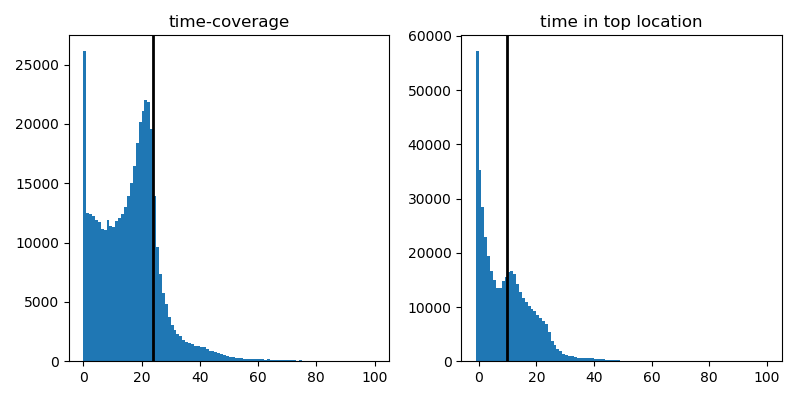

In [115]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('time-coverage')
plt.hist(np.array(list(zip(*save_data))[-1])/(60*60),np.linspace(0,100,101))
plt.axvline(x=24,color='black',lw=2)

plt.subplot(1,2,2)
plt.title('time in top location')
plt.hist(np.array(list(zip(*save_data))[5])/(60*60),np.linspace(-1,100,102))
plt.axvline(x=10,color='black',lw=2)

plt.tight_layout()
plt.show()

In [119]:
x = pd.DataFrame(save_data,columns=['u','admin_label','dist','pois','rg','time_at_home','lat','lon','urban','coverage'])

,u,admin_label,dist,pois,rg,time_at_home,lat,lon,urban,coverage
1,0003585182a39224e9504892436f8357578be0d51ec0ab...,COL.5.8_1,3.812504,1,0.000000,38079,9.239011,-74.758860,0,52683
2,000626ed90574278bc662b53605fdfb046b14403bb39cb...,COL.19.19_1,109.970753,3,40.215117,4507,11.228942,-74.198484,0,75567
3,000a203018b3420d2301a90cc749b96ba8f794acd3f72d...,COL.30.32_1,9.227363,1,0.000000,5641,3.381798,-76.529125,0,76251
5,000b7772f9a214f457f9b7d6b9796c8641a96a4531f7ed...,COL.14.9_1,22.726884,2,5.828004,54269,4.735274,-74.345550,0,72692
7,0017406b4003cd8ab7e95b4148866d1c6646d64b2ef83e...,COL.21.50_1,0.000000,1,-1.000000,69135,1.222229,-77.272339,0,69135
...,...,...,...,...,...,...,...,...,...,...
439968,fff0822c083b60f44781b3d27b26b7c7bef127c19b4faf...,COL.7.9_1,33.541510,1,0.000000,52294,5.072937,-75.525513,0,76302
439969,fff744872b8cebde02a95f66f3e6d15cdecd1828608c01...,COL.30.32_1,20.903071,2,7.101703,41628,3.469116,-76.524910,0,73750
439970,fff9d41baeb64ca84b1edf7bfeaeaf2814947a6389e249...,COL.2.16_1,6.819239,1,0.000000,64372,6.341858,-75.569458,0,82581
439971,fffd66a54483aefd754765a9e9f07c02dd410d183c40ad...,COL.2.38_1,0.029418,1,-1.000000,68578,6.343628,-75.540318,0,68578


<IPython.core.display.Javascript object>


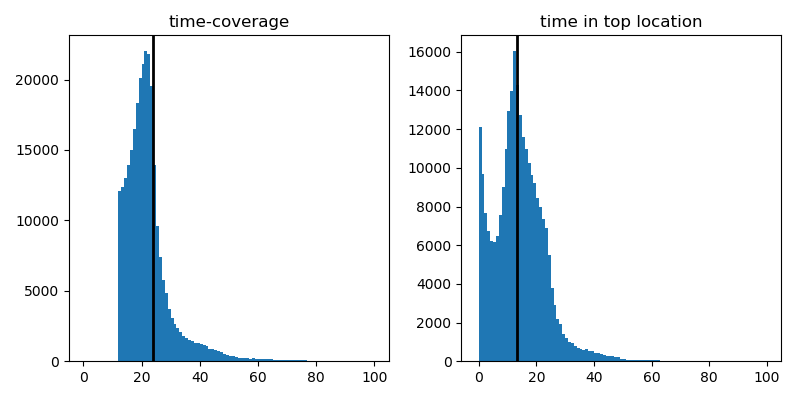

In [126]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('time-coverage')
plt.hist(x[x['coverage'] >= 60*60*12]['coverage']/(60*60),np.linspace(0,100,101))
plt.axvline(x=24,color='black',lw=2)

plt.subplot(1,2,2)
plt.title('time in top location')
plt.hist(x[(x['coverage'] >= 60*60*12) & (x['admin_label']!= -1)]['time_at_home']/(60*60),np.linspace(-1,100,102))
plt.axvline(x=np.median(x[(x['coverage'] >= 60*60*12) & (x['admin_label']!= -1)]['time_at_home']/(60*60)),color='black',lw=2)

plt.tight_layout()
plt.show()

__old data__

In [6]:
t_day = datetime(2020,2,1)
t_end = datetime(2020,2,1)
country = 'COL'

In [7]:
# define paths
stop_path = "/home/vsekara/mb_data/cuebiq/nCoV/POI/%s/stops_gz_level_2/" % country
interval_path = "/home/vsekara/mb_data/cuebiq/nCoV/POI/%s/intervals_gz/" % country

# load urban raster
urban_raster, urban_band, urban_max_row, urban_max_col = load_urban_raster()
if country in countries_with_povdata:
    poverty_raster, poverty_band, pov_max_row, pov_max_col = load_poverty_raster(country)
    POVERTY = True
    columns = ['useruuid','admin1','distance_travelled','number_of_pois','radius_of_gyration',
                'time_at_home','latitude','longitude','urban','poverty']
else:
    POVERTY = False
    columns = ['useruuid','admin1','distance_travelled','number_of_pois',
                'radius_of_gyration','time_at_home','latitude','longitude','urban']


# iterate of days
while t_day <= t_end:
    day = t_day.strftime('%Y%m%d00')

    # print the file it is starting to work on
    print(country,day)

    # find files to iterate
    files = os.listdir(interval_path + day )

    # create Counter to store daily user travel distances - because some users are split between files
    day_dist = Counter()
    # create dict to store time spent at locations (another small issue here is because Laura has set the threshold to 
    # 3 hours, and because some phones do not collect GPS data unless there is an activity we might not have data for 
    # some users. We assume that users are at home unless specified otherwise)
    day_visits_old = defaultdict(list)

    for file in files:
        # load interval data
        interval_data = load_interval_data(interval_path,day,file)
        # load stops data
        stops_data = load_stops_data(stop_path,day,file)
        # create stop_to_admin1 map
        stops_to_admin1 = dict(zip(stops_data['label'],stops_data['GID_2']))
        # create stops to gps pos
        stops_to_pos = dict(zip(stops_data['label'],zip(stops_data['latitude'],stops_data['longitude'])))

        # DISTANCE CALCULATION
        dist = interval_data.groupby('useruuid').agg({'distance':'sum'}).reset_index()
        # update day_dist counter
        for u,d in dist.values:
            day_dist[u] += d

        # HOME LOCATION COUNT
        visits = (interval_data.groupby('useruuid')
                          .agg({'start': list, 'end': list,
                                'classification_type': list,
                                'label': list
                              }).reset_index()[['useruuid','classification_type','label','start','end']].values)
        # append to day visits dictionary
        for u,c_type,label,start,end in visits:
            day_visits_old[u].extend(list(zip(c_type,label,[stops_to_admin1.get(l,-1) for l in label],
                                                 [stops_to_pos.get(l,-1) for l in label],start,end)))

    # after going through files  calculate statistics
    save_data_old = []
    for u,v in day_visits_old.items():

        # unpack list of tuples
        types,labels,admins,positions,starts,ends = zip(*v)

        # find home location
        (home_label,admin_label),time_at_home = infer_home_label(types,labels,admins,starts,ends)

        # calculate radius of gyration
        rg = calculate_radius_of_gyration(labels,positions,home_label)

        # calculate number of points of interest 
        pois = len([l for l in set(labels) if l!=-1])

        # get urban label of home area
        if home_label!=-1:
            # find home gps locations
            lat,lon = positions[labels.index(home_label)]
            urban = get_value_from_raster(urban_raster,urban_band,lat,lon,urban_max_row,urban_max_col)
        else:
            urban = -1
            lat,lon = float("NaN"),float("NaN")
        save_row = (u,admin_label,day_dist[u],pois,rg,time_at_home,lat,lon,urban)

        # append data to list
        save_data_old.append(save_row)

    t_day += timedelta(days=1)

COL 2020020100


## compare things

In [23]:
#test_u = '009bf499220a7ea7f4827ca16c9cb661eaed78012457797dab9b9b03af386b38'
test_u = '8944baf7bb188545e6313394daf790feade43d839ffe68003c5d52dd0b447c6d'

In [35]:
[i for i in save_data if i[0] == test_u][0]

('8944baf7bb188545e6313394daf790feade43d839ffe68003c5d52dd0b447c6d',
 'COL.2.68_1',
 146.30563396855683,
 2,
 3.09819638375012,
 11636,
 6.2535059,
 -75.6008626,
 1)

In [36]:
[i for i in save_data_old if i[0] == test_u][0]

('8944baf7bb188545e6313394daf790feade43d839ffe68003c5d52dd0b447c6d',
 'COL.2.68_1',
 159.16767607890924,
 3,
 2.537265566626093,
 65624,
 6.2535962000000005,
 -75.60084549999999,
 1)

In [28]:
[(i[0],i[1],i[2],i[3],datetime.utcfromtimestamp(i[4]),datetime.utcfromtimestamp(i[5])) for i in day_visits[test_u]]


[("{'OTHER'}",
  22607,
  'COL.2.68_1',
  (6.2535059, -75.6008626),
  datetime.datetime(2020, 1, 31, 21, 17, 46),
  datetime.datetime(2020, 2, 1, 0, 31, 42)),
 ("{'OTHER'}",
  -1,
  -1,
  -1,
  datetime.datetime(2020, 2, 1, 11, 5, 40),
  datetime.datetime(2020, 2, 1, 16, 39, 24)),
 ("{'OTHER'}",
  1009,
  'COL.2.68_1',
  (6.2163051, -75.5877943),
  datetime.datetime(2020, 2, 1, 16, 49, 7),
  datetime.datetime(2020, 2, 1, 17, 9, 13)),
 ("{'OTHER'}",
  -1,
  -1,
  -1,
  datetime.datetime(2020, 2, 1, 17, 28, 6),
  datetime.datetime(2020, 2, 1, 22, 16, 27))]

In [29]:
sorted([(i[0],i[1],i[2],i[3],datetime.utcfromtimestamp(i[4]),datetime.utcfromtimestamp(i[5])) for i in day_visits_old[test_u]],key=operator.itemgetter(4))


[("{'OTHER'}",
  3687,
  'COL.2.68_1',
  (6.2535962000000005, -75.60084549999999),
  datetime.datetime(2020, 1, 31, 21, 17, 46),
  datetime.datetime(2020, 2, 1, 15, 31, 30)),
 ("{'OTHER'}",
  3691,
  'COL.2.68_1',
  (6.2524168, -75.6009853),
  datetime.datetime(2020, 1, 31, 23, 36),
  datetime.datetime(2020, 2, 1, 0, 27, 39)),
 ("{'OTHER'}",
  -1,
  -1,
  -1,
  datetime.datetime(2020, 2, 1, 11, 5, 40),
  datetime.datetime(2020, 2, 1, 14, 52, 38)),
 ("{'OTHER'}",
  -1,
  -1,
  -1,
  datetime.datetime(2020, 2, 1, 14, 58, 8),
  datetime.datetime(2020, 2, 1, 16, 39, 24)),
 ("{'OTHER'}",
  -1,
  -1,
  -1,
  datetime.datetime(2020, 2, 1, 16, 20, 20),
  datetime.datetime(2020, 2, 1, 17, 35, 38)),
 ("{'OTHER'}",
  3498,
  'COL.2.68_1',
  (6.21630245, -75.58773825),
  datetime.datetime(2020, 2, 1, 16, 49, 7),
  datetime.datetime(2020, 2, 1, 17, 9, 13)),
 ("{'OTHER'}",
  -1,
  -1,
  -1,
  datetime.datetime(2020, 2, 1, 17, 28, 6),
  datetime.datetime(2020, 2, 1, 17, 58, 27)),
 ("{'OTHER'}",
  -1,

__look at raw data__

In [30]:
path = "/home/vsekara/mb_data/cuebiq-raw/COL/2020020100/"
df = []
for i in range(25):
    x = pd.read_csv(path + 'part-%05d-e9dfedf3-8fde-494a-86d6-46453d3de185-c000.csv.gz' % i,compression='gzip',sep='\t',
               names = ['t','uid','d_type','lat','lon','acc','tz','type_','c_type'])
    
    x = x[x['uid'] == test_u]
    
    df.append(x)
    
df = pd.concat(df)
df = df.sort_values(by=['t'])
df['t'] = df['t'].map(datetime.utcfromtimestamp)

In [31]:
import folium

In [33]:
m = folium.Map(
    location=[3.325, -76.237],
    #tiles='Stamen Terrain',
    zoom_start=13
)

for lat,lon,t in zip(df['lat'],df['lon'],df['t']):
    folium.Marker(
        [lat, lon],
        popup=t.strftime('%d/%m %H:%M:%S'),
    ).add_to(m)

m

In [38]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [48]:
acc = 100

6.2541639

In [56]:
df['lon'].min()

-75.66390179999999

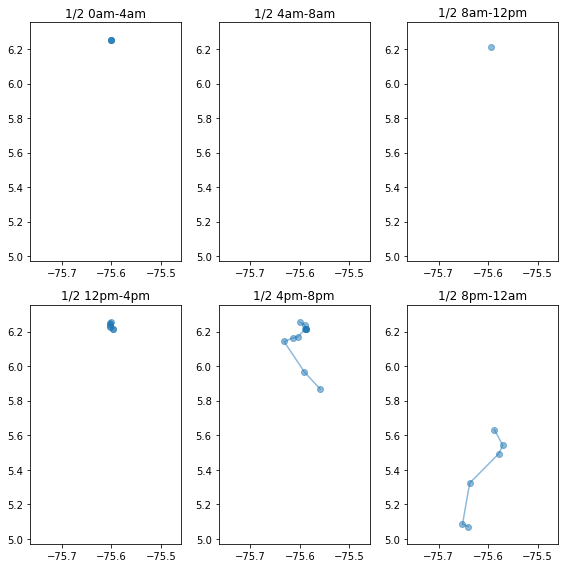

In [57]:
plt.figure(figsize=(8,8))
t_start=datetime(2020,2,1)

x_min, x_max = df['lon'].min()-0.1, df['lon'].max()+0.1
y_min, y_max = df['lat'].min()-0.1, df['lat'].max()+0.1

plt.subplot(2,3,1)
plt.title('1/2 0am-4am')
plt.plot(df[(df['acc']<acc) & (df['t'] < t_start+timedelta(hours=4))]['lon'],
         df[(df['acc']<acc) & (df['t'] < t_start+timedelta(hours=4))]['lat'],
         '-o',alpha=0.5)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.subplot(2,3,2)
plt.title('1/2 4am-8am')
plt.plot(df[(df['acc']<acc) & (t_start+timedelta(hours=4) <= df['t']) & (df['t'] < t_start+timedelta(hours=8))]['lon'],
         df[(df['acc']<acc) & (t_start+timedelta(hours=4) <= df['t']) & (df['t'] < t_start+timedelta(hours=8))]['lat']
         ,'-o',alpha=0.5)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.subplot(2,3,3)
plt.title('1/2 8am-12pm')
plt.plot(df[(df['acc']<acc) & (t_start+timedelta(hours=8) <= df['t']) & (df['t'] < t_start+timedelta(hours=12))]['lon'],
         df[(df['acc']<acc) & (t_start+timedelta(hours=8) <= df['t']) & (df['t'] < t_start+timedelta(hours=12))]['lat']
         ,'-o',alpha=0.5)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.subplot(2,3,4)
plt.title('1/2 12pm-4pm')
plt.plot(df[(df['acc']<acc) & (t_start+timedelta(hours=12) <= df['t']) & (df['t'] < t_start+timedelta(hours=16))]['lon'],
         df[(df['acc']<acc) & (t_start+timedelta(hours=12) <= df['t']) & (df['t'] < t_start+timedelta(hours=16))]['lat']
         ,'-o',alpha=0.5)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.subplot(2,3,5)
plt.title('1/2 4pm-8pm')
plt.plot(df[(df['acc']<acc) & (t_start+timedelta(hours=16) <= df['t']) & (df['t'] < t_start+timedelta(hours=20))]['lon'],
         df[(df['acc']<acc) & (t_start+timedelta(hours=16) <= df['t']) & (df['t'] < t_start+timedelta(hours=20))]['lat']
         ,'-o',alpha=0.5)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.subplot(2,3,6)
plt.title('1/2 8pm-12am')
plt.plot(df[(df['acc']<acc) & (t_start+timedelta(hours=20) <= df['t'])]['lon'],
         df[(df['acc']<acc) & (t_start+timedelta(hours=20) <= df['t'])]['lat']
         ,'-o',alpha=0.5)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.tight_layout()
plt.show()

In [68]:
#df[df['acc']<100]
df

,t,uid,d_type,lat,lon,acc,tz,type_,c_type
7550,2020-01-31 21:17:46,8944baf7bb188545e6313394daf790feade43d839ffe68...,0,6.253611,-75.600828,27.44,-18000,OTHER,KEEP
43343,2020-01-31 23:36:00,8944baf7bb188545e6313394daf790feade43d839ffe68...,0,6.252417,-75.600985,700.00,-18000,OTHER,KEEP
25529,2020-01-31 23:56:01,8944baf7bb188545e6313394daf790feade43d839ffe68...,0,6.253628,-75.600866,23.61,-18000,OTHER,KEEP
49870,2020-02-01 00:27:39,8944baf7bb188545e6313394daf790feade43d839ffe68...,0,6.252417,-75.600985,700.00,-18000,OTHER,KEEP
446,2020-02-01 00:31:42,8944baf7bb188545e6313394daf790feade43d839ffe68...,0,6.253506,-75.600863,25.45,-18000,OTHER,KEEP
28716,2020-02-01 11:05:40,8944baf7bb188545e6313394daf790feade43d839ffe68...,0,6.213929,-75.594906,22.40,-18000,OTHER,KEEP
23063,2020-02-01 14:47:28,8944baf7bb188545e6313394daf790feade43d839ffe68...,0,6.213908,-75.595837,40.09,-18000,OTHER,KEEP
15270,2020-02-01 14:52:38,8944baf7bb188545e6313394daf790feade43d839ffe68...,0,6.216911,-75.597673,53.33,-18000,OTHER,KEEP
11924,2020-02-01 14:58:08,8944baf7bb188545e6313394daf790feade43d839ffe68...,0,6.227933,-75.601925,74.91,-18000,OTHER,KEEP
19442,2020-02-01 15:02:10,8944baf7bb188545e6313394daf790feade43d839ffe68...,0,6.230192,-75.602216,31.48,-18000,OTHER,KEEP
